# Univariate risk management

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms and Q-Q plots
    
    
- Market risk metrics
    - Value-at-Risk
    - Expected Shortfall
    
    
- Different approaches
    - Historical Simulation
    - Parametric estimation: Normal, t-Student
    - Extreme Value Theory: Block maxima and GEV, Excess Distribution Over a Threshold
    - GARCH and Filtered HS
    
    
- Backtesting
    - Binomial test
    
    
    
## References
- [Risk in Perspective](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_01.pdf)
- [Basic Concepts in Risk Management](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_02.pdf)
- [Financial Time Series](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_04.pdf)
- [Financial Markets, Prices and Risk](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-1.pdf)
- [Risk Measures](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-4.pdf)
- [Univariate Volatility Modeling](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-2.pdf)
- [Extreme Value Theory](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-9.pdf)

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

## Data

### Upload and visualize data

Get the data for the stock Apple by specifying the stock ticker, start date, and end date

In [ ]:
# Students are advised to use other data sources. This is just for the sake of brevity.
# !pip install yfinance

In [3]:
import yfinance as yf

prices = yf.download('AAPL','2016-01-01','2019-12-31')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,26.752501,26.757500,26.205000,26.315001,24.422157,163649200
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.443037,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.830513,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.364161,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.378082,324377600


We'll use `Adjusted Close` to account for dividends and stock splits. Yahoo finance accounts for stock splits even in their `Close` price. However, some other data vendors don't (e.g. *Finam*). Pay attention.

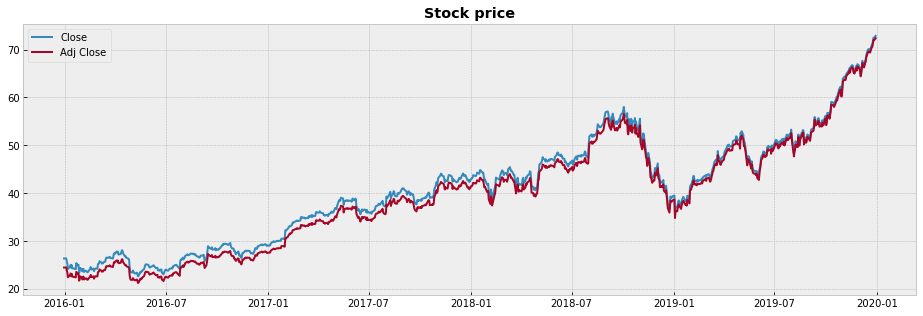

In [4]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

We convert datetime index to period

In [5]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)
PeriodIndex(['2015-12-31', '2016-01-04', '2016-01-05', '2016-01-06',
             '2016-01-07', '2016-01-08', '2016-01-11', '2016-01-12',
             '2016-01-13', '2016-01-14',
             ...
             '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
             '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
             '2019-12-27', '2019-12-30'],
            dtype='period[D]', name='Date', length=1006, freq='D')


In [6]:
price = prices['Adj Close']

price.head()

Date
2015-12-31    24.422157
2016-01-04    24.443037
2016-01-05    23.830513
2016-01-06    23.364161
2016-01-07    22.378082
Freq: D, Name: Adj Close, dtype: float64

We can calculate absolute difference in prices, logarithmic returns and arithmetic returns

In [7]:
dX = price.diff()

ret_log = np.log(price).diff()

ret = price.pct_change()

ret

Date
2015-12-31         NaN
2016-01-04    0.000855
2016-01-05   -0.025059
2016-01-06   -0.019570
2016-01-07   -0.042205
                ...   
2019-12-23    0.016318
2019-12-24    0.000951
2019-12-26    0.019840
2019-12-27   -0.000379
2019-12-30    0.005935
Freq: D, Name: Adj Close, Length: 1006, dtype: float64

In [8]:
ret = ret.dropna()

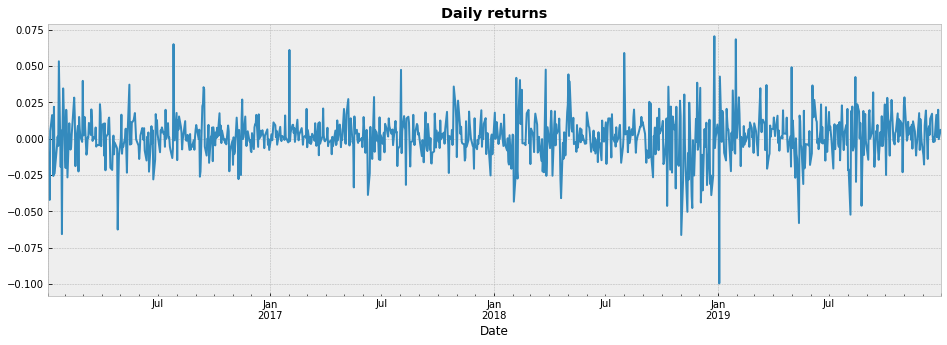

In [9]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

### Plot histograms and Q-Q plots

Explore the Returns Distribution

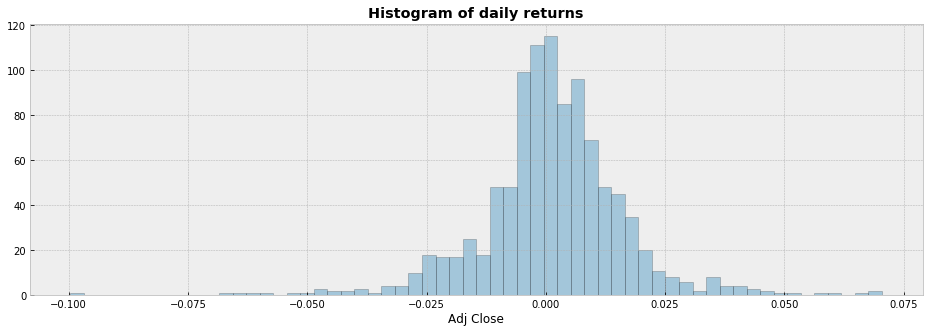

In [12]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

This doesn't look very much like a normal distribution... let's check.

In [13]:
import scipy.stats as ss

params_norm = ss.norm.fit(ret)

print(params_norm)

(0.0011994533754616345, 0.015324624458658637)


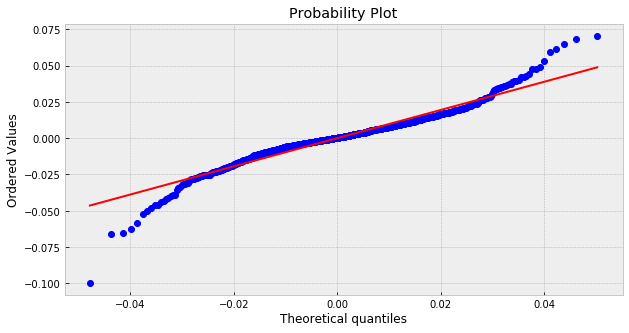

In [14]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)

plt.show()

By the way, the documentation for `ss.probplot` is misleading. This is a Q-Q plot up to the axes ticks. At least `statsmodels` calls this a Q-Q plot.

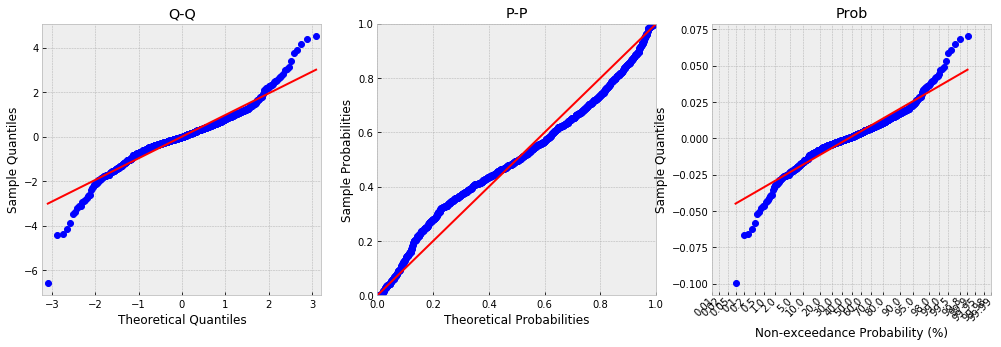

In [13]:
import statsmodels.graphics.gofplots
pp = statsmodels.graphics.gofplots.ProbPlot(ret, fit=True)

fig = plt.figure(figsize=(17, 5))

plt1 = fig.add_subplot(1,3,1)
plt2 = fig.add_subplot(1,3,2)
plt3 = fig.add_subplot(1,3,3)

pp.qqplot(ax=plt1.axes, line='r')
plt1.set_title('Q-Q')

pp.ppplot(ax=plt2.axes, line='45')
plt2.set_title('P-P')

pp.probplot(ax=plt3.axes, line='r')
plt3.set_title('Prob')

plt.show()

## Market risk metrics

### Value-at-Risk visualization

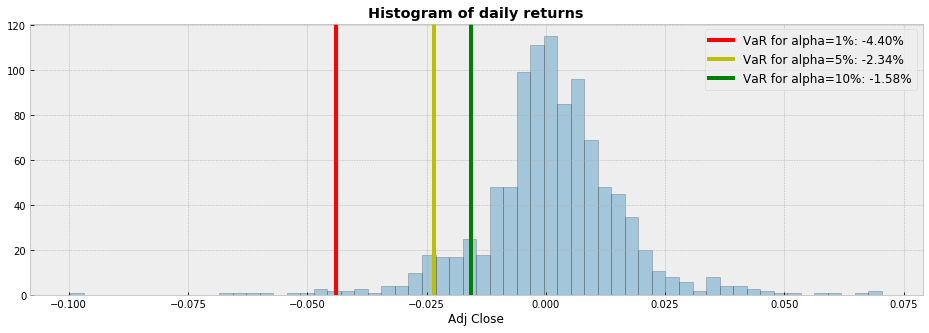

In [15]:
VaR_HS_01 = ret.quantile(0.01)
VaR_HS_05 = ret.quantile(0.05)
VaR_HS_10 = ret.quantile(0.10)

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
plt.axvline(x=VaR_HS_05, linewidth=4, color="y")
plt.axvline(x=VaR_HS_10, linewidth=4, color="g")

plt.title("Histogram of daily returns", weight="bold")

plt.legend(['VaR for alpha=1%: {:.2f}%'.format(100*VaR_HS_01),
            'VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS_05),
            'VaR for alpha=10%: {:.2f}%'.format(100*VaR_HS_10)], fontsize=12)

plt.show()

### Expected Shortfall visualization

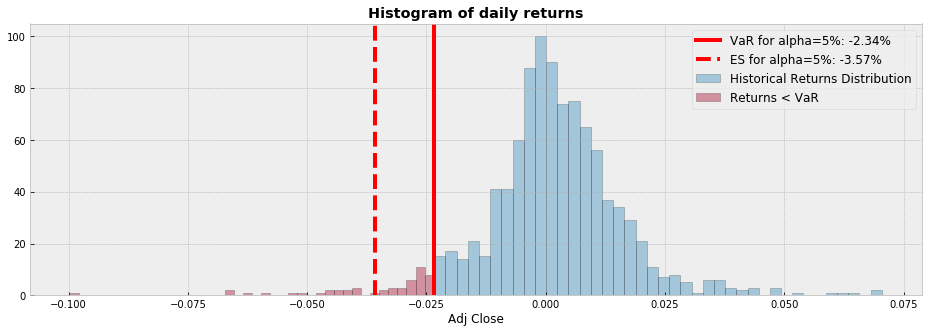

In [16]:
alpha = 0.05

VaR_HS = ret.quantile(alpha)
ES_HS = ret[ret < VaR_HS].mean()

fig = plt.figure(figsize=(16, 5))

sns.distplot(ret[ret >= VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(ret[ret < VaR_HS], hist=True, kde=False, 
             bins=40,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.axvline(x=VaR_HS, linewidth=4, color="r")
plt.axvline(ES_HS, linewidth=4, color='red', linestyle='dashed')

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['VaR for alpha=5%: {:.2f}%'.format(100*VaR_HS),
            'ES for alpha=5%: {:.2f}%'.format(100*ES_HS),
            'Historical Returns Distribution', 
            'Returns < VaR'], fontsize=12)

plt.show()

## Different approaches

### Historical Simulation

In [17]:
def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)

In [18]:
# This could also be accomodated to handle L_history of type pd.TimeDelta like '1 year'

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [19]:
VaR_HS = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=alpha)

VaR_HS

Date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
                ...   
2019-12-23   -0.021427
2019-12-24   -0.021018
2019-12-26   -0.020742
2019-12-27   -0.020742
2019-12-30   -0.020742
Freq: D, Name: calculate_VaR_HS, Length: 1005, dtype: float64

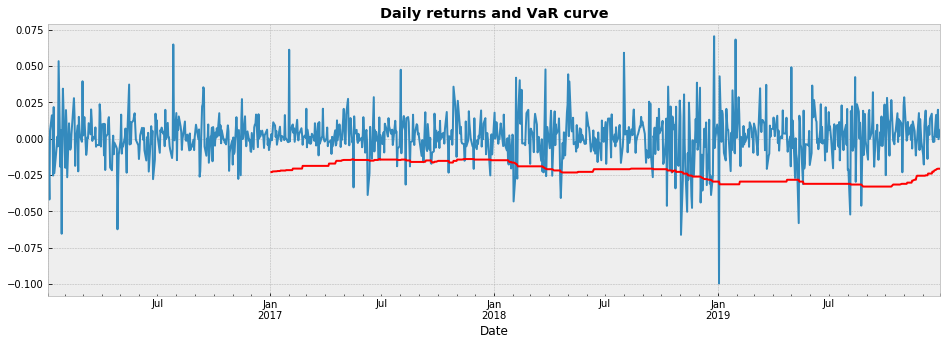

In [20]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot(color='r')

plt.title("Daily returns and VaR curve", weight="bold")

plt.show()

### Parametric estimation

#### Normal distribution

In [21]:
import scipy.stats as ss

params_norm = ss.norm.fit(ret)
norm_mean, norm_sigma = params_norm

VaR_norm = ss.norm.ppf(alpha, norm_mean, norm_sigma)
ES_norm = ss.norm.expect(loc=norm_mean, scale=norm_sigma, ub=VaR_norm, conditional=True)

print('Estimated parameters: mean={:.2f}, scale={:.2f}'.format(norm_mean, norm_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_norm))
print('Expected Shortfall: {:.2f}%'.format(100*ES_norm))

Estimated parameters: mean=0.00, scale=0.02
Value-at-Risk: -2.40%
Expected Shortfall: -3.04%


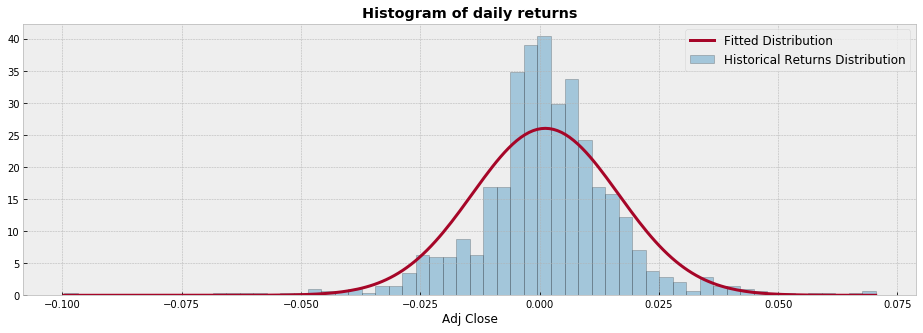

In [22]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = ss.norm.pdf(x, *params_norm)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)

plt.show()

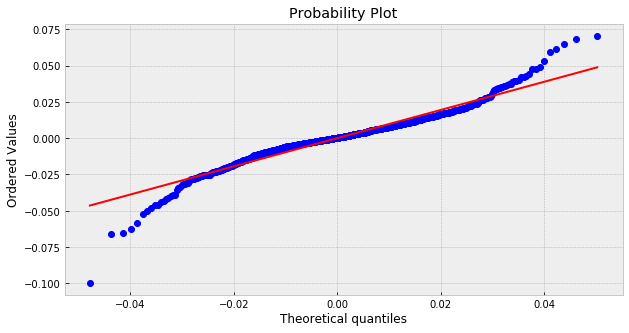

In [23]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.norm(*params_norm), plot=plt)
plt.show()

#### t-Student distribution

In [24]:
params_t = ss.t.fit(ret)
t_df, t_mean, t_sigma = params_t

VaR_t = ss.t.ppf(alpha, t_df, t_mean, t_sigma)
ES_t = ss.t.expect(args=(t_df,), loc=t_mean, scale=t_sigma, ub=VaR_t, conditional=True)

print('Estimated parameters: df={:.2f}, mean={:.2f}, scale={:.2f}'.format(t_df, t_mean, t_sigma))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_t))
print('Expected Shortfall: {:.2f}%'.format(100*ES_t))

Estimated parameters: df=2.97, mean=0.00, scale=0.01
Value-at-Risk: -2.15%
Expected Shortfall: -3.65%


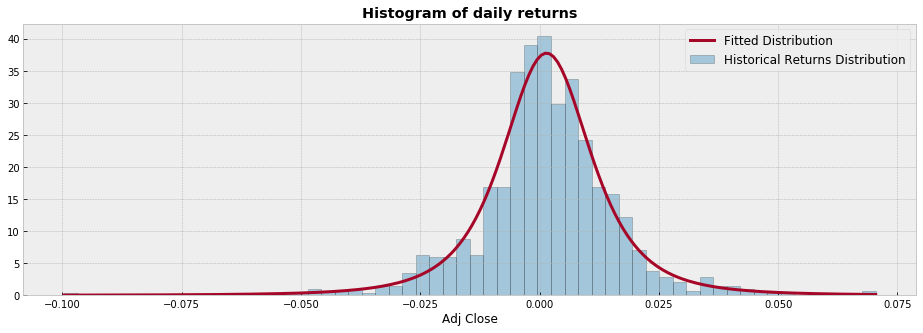

In [25]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = ss.t.pdf(x, *params_t)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)


plt.show()

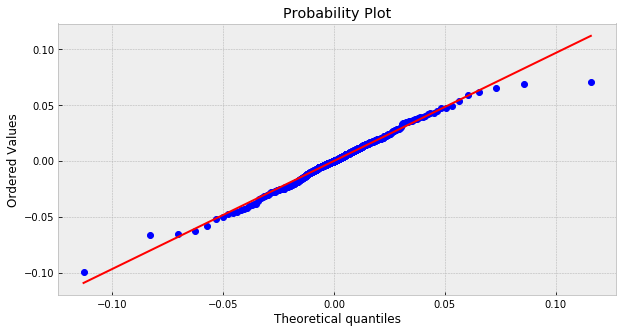

In [26]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.t(*params_t), plot=plt)
plt.show()

#### Wrapping into functions

In [27]:
def calculate_VaR_normal(ret, alpha=0.05):

    params_norm = ss.norm.fit(ret)
    
    return ss.norm.ppf(alpha, *params_norm)


def calculate_VaR_t(ret, alpha=0.05):

    params_t = ss.t.fit(ret)
    
    return ss.t.ppf(alpha, *params_t)

In [28]:
VaR_norm = calc_VaR(ret, calculate_VaR_normal, L_history=252, level=alpha)

VaR_t = calc_VaR(ret, calculate_VaR_t, L_history=252, level=alpha)

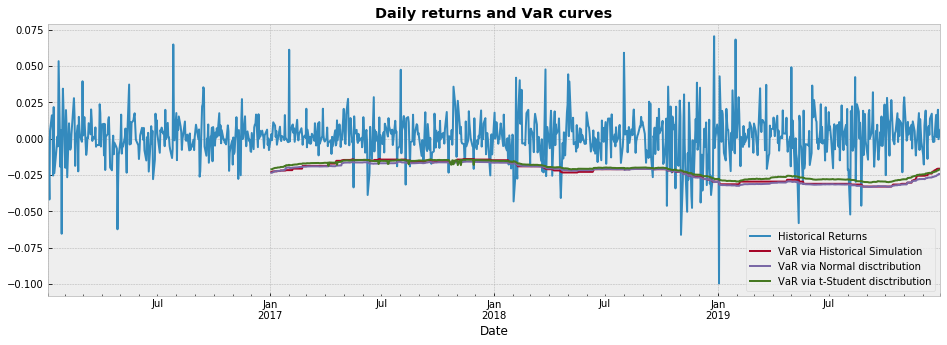

In [29]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
VaR_norm.plot()
VaR_t.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
            'VaR via Normal disctribution',
            'VaR via t-Student disctribution'])

plt.show()

### Extreme Value Theory


#### Block maxima and Generalized Extreme Value Distribution (GEV)

Resample losses with desired period (e.g. weekly)

In [30]:
maximas = ret.resample('W').min()

In [31]:
ret

Date
2016-01-04    0.000819
2016-01-05   -0.024959
2016-01-06   -0.019723
2016-01-07   -0.041952
2016-01-08    0.005362
                ...   
2019-12-23    0.016287
2019-12-24    0.000993
2019-12-26    0.019836
2019-12-27   -0.000417
2019-12-30    0.005976
Freq: D, Name: Adj Close, Length: 1005, dtype: float64

In [32]:
maximas

Date
2016-01-04/2016-01-10   -0.041952
2016-01-11/2016-01-17   -0.025442
2016-01-18/2016-01-24   -0.005343
2016-01-25/2016-01-31   -0.065517
2016-02-01/2016-02-07   -0.026631
                           ...   
2019-12-02/2019-12-08   -0.017838
2019-12-09/2019-12-15   -0.013986
2019-12-16/2019-12-22   -0.002298
2019-12-23/2019-12-29   -0.000417
2019-12-30/2020-01-05    0.005976
Freq: W-SUN, Name: Adj Close, Length: 209, dtype: float64

In [33]:
params_genextreme = ss.genextreme.fit(maximas)
c, loc, scale = params_genextreme
xi = -c

VaR_genextreme = loc + scale / xi * (1 - (-5*np.log(1-alpha)) ** (-xi) )
# VaR_genextreme = ss.genextreme.ppf(alpha**(-5), *params_genextreme)


print('Estimated parameters: c={:.2f}, mean={:.2f}, scale={:.2f}'.format(c, loc, scale))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_genextreme))
# print('Expected Shortfall: {:.2f}%'.format(100*ES_genpareto))

Estimated parameters: c=0.59, mean=-0.02, scale=0.02
Value-at-Risk: -3.15%


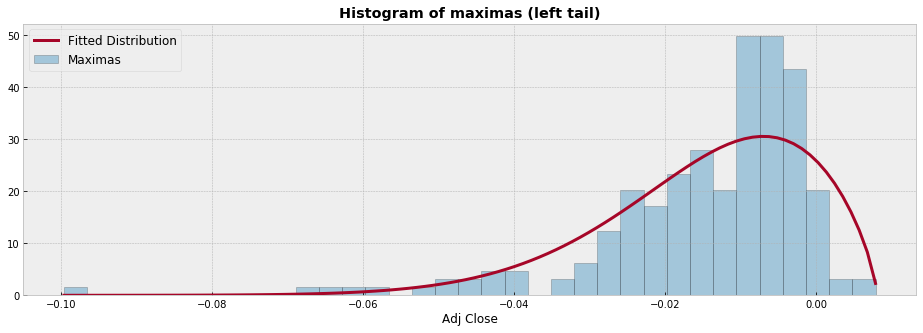

In [34]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(maximas.min(), maximas.max(), 100)

y_pdf = ss.genextreme.pdf(x, *params_genextreme)

sns.distplot(maximas, hist=True, kde=False, 
             bins=35, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of maximas (left tail)", weight="bold")
plt.legend(['Fitted Distribution', 'Maximas'], fontsize=12)

plt.show()

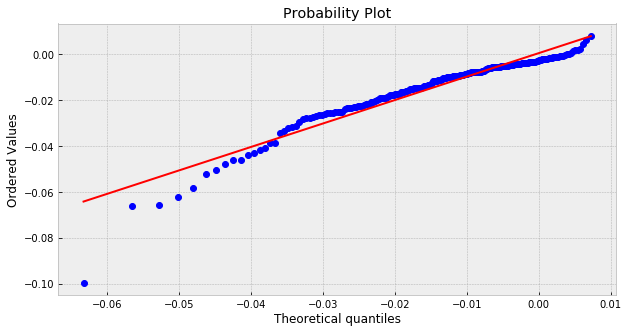

In [35]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(maximas, dist=ss.genextreme(*params_genextreme), plot=plt)
plt.show()

#### Excess Distribution Over a Threshold

In [36]:
u = ret.quantile(0.2)

print(u)

ret_tail = ret[ret <= u]

-0.007876360495034838


In [37]:
params_genpareto = ss.genpareto.fit(-ret_tail, loc=0)
c, loc, scale = params_genpareto

VaR_genpareto = u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)
ES_genpareto = VaR_genpareto / (1 - c) - (scale - c*u) / (1 - c)

print('Estimated parameters: c={:.2f}, mean={:.2f}, scale={:.2f}'.format(c, loc, scale))
print('Value-at-Risk: {:.2f}%'.format(100*VaR_genpareto))
print('Expected Shortfall: {:.2f}%'.format(100*ES_genpareto))

Estimated parameters: c=0.02, mean=0.01, scale=0.01
Value-at-Risk: -2.36%
Expected Shortfall: -3.55%


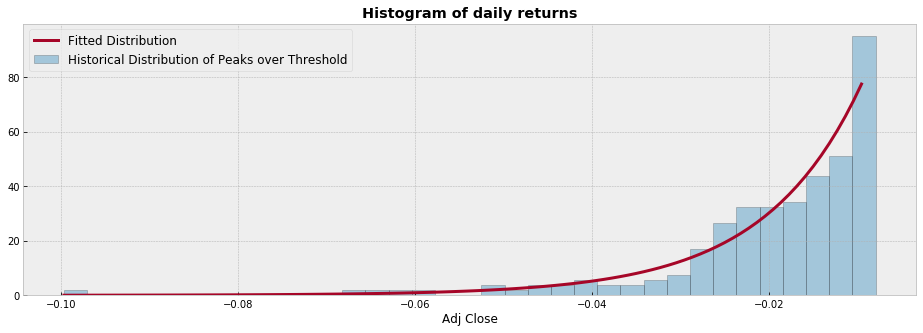

In [38]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret_tail.min(), ret_tail.max()*1.2, 100)

y_pdf = ss.genpareto.pdf(-x, *params_genpareto)

sns.distplot(ret_tail, hist=True, kde=False, 
             bins=35, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Distribution of Peaks over Threshold'], fontsize=12)

plt.show()

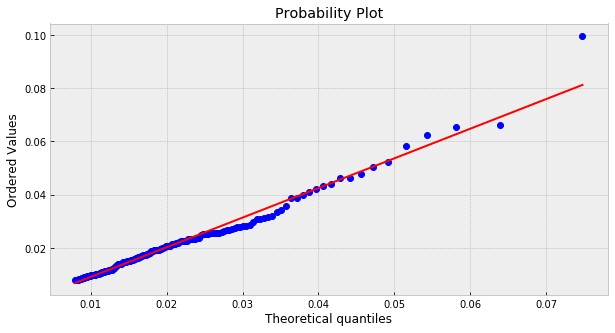

In [39]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(-ret_tail, dist=ss.genpareto(*params_genpareto), plot=plt)
plt.show()

#### Wrapping into functions

In [40]:
def calculate_VaR_pot(ret, alpha=0.05):
    
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    
    return u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)


def calculate_VaR_maximas(ret, alpha=0.05):
    
    maximas = ret.resample('W').min()
    
    params_genextreme = ss.genextreme.fit(maximas)
    c, loc, scale = params_genextreme
    xi = -c

    return loc + scale / xi * (1 - (-5*np.log(1-alpha)) ** (-xi) )

In [46]:
VaR_pot = calc_VaR(ret, calculate_VaR_pot, L_history=252, level=alpha)
VaR_maximas = calc_VaR(ret, calculate_VaR_maximas, L_history=252, level=alpha)

C:\Users\stepa\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2247: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
C:\Users\stepa\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1035: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
C:\Users\stepa\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\stepa\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2364: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


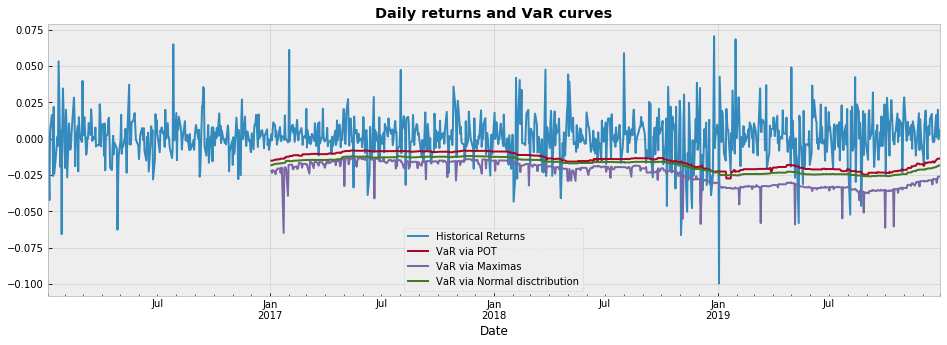

In [47]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_pot.plot()
VaR_maximas.plot()
VaR_norm.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via POT',
            'VaR via Maximas', 
           'VaR via Normal disctribution'])

plt.show()

### GARCH models

#### GARCH with parametric distribution of residuals

In [34]:
# https://arch.readthedocs.io/en/latest/univariate/introduction.html
# !pip install arch

Fit a default model

In [10]:
from arch import arch_model 

mdl = arch_model(100 * ret) # * 100 because it asked to do so

res = mdl.fit()

res

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1799.2050440052599
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1797.529751219712
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1796.5148519177583
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1796.207101605276
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1796.1844830819623
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1796.1713661331746
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1796.0948680155961
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1796.0940029861645
Iteration:      9,   Func. Count:     64,   Neg. LLF: 1796.0939906777085
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1796.093990677457
            Iterations: 9
            Function evaluations: 64
            Gradient evaluations: 9


                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                      -0.003
Mean Model:             Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:               -1796.09
Distribution:                  Normal   AIC:                           3600.19
Method:            Maximum Likelihood   BIC:                           3619.84
                                        No. Observations:                 1005
Date:                Tue, Sep 15 2020   Df Residuals:                     1001
Time:                        00:40:35   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2072  4.707e-02      4.401  1.076e-05 [  0.115,  0.29

Look at the parameters to choose

In [11]:
dist = 'skewstudent'

mdl = arch_model(100 * ret,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

res = mdl.fit()
res

Iteration:      1,   Func. Count:     10,   Neg. LLF: 1710.1540891575544
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1709.8536059315288
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1708.3231523935726
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1708.0693427767196
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1707.1589116627788
Iteration:      6,   Func. Count:     70,   Neg. LLF: 1704.9833462365862
Iteration:      7,   Func. Count:     82,   Neg. LLF: 1704.7189537815434
Iteration:      8,   Func. Count:     93,   Neg. LLF: 1702.9479784514738
Iteration:      9,   Func. Count:    104,   Neg. LLF: 1700.9141920002407
Iteration:     10,   Func. Count:    115,   Neg. LLF: 1700.6067970871864
Iteration:     11,   Func. Count:    126,   Neg. LLF: 1700.369450819459
Iteration:     12,   Func. Count:    136,   Neg. LLF: 1700.1164238759538
Iteration:     13,   Func. Count:    146,   Neg. LLF: 1700.06842448646
Iteration:     14,   Func. Count:    156,   Neg. LLF: 

                              HAR - GJR-GARCH Model Results                              
Dep. Variable:                         Adj Close   R-squared:                      -0.000
Mean Model:                                  HAR   Adj. R-squared:                 -0.001
Vol Model:                             GJR-GARCH   Log-Likelihood:               -1700.07
Distribution:      Standardized Skew Student's t   AIC:                           3416.13
Method:                       Maximum Likelihood   BIC:                           3455.42
                                                   No. Observations:                 1004
Date:                           Tue, Sep 15 2020   Df Residuals:                      996
Time:                                   00:40:47   Df Model:                            8
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------

Here we can see fitted conditional volatility and standartized residuals

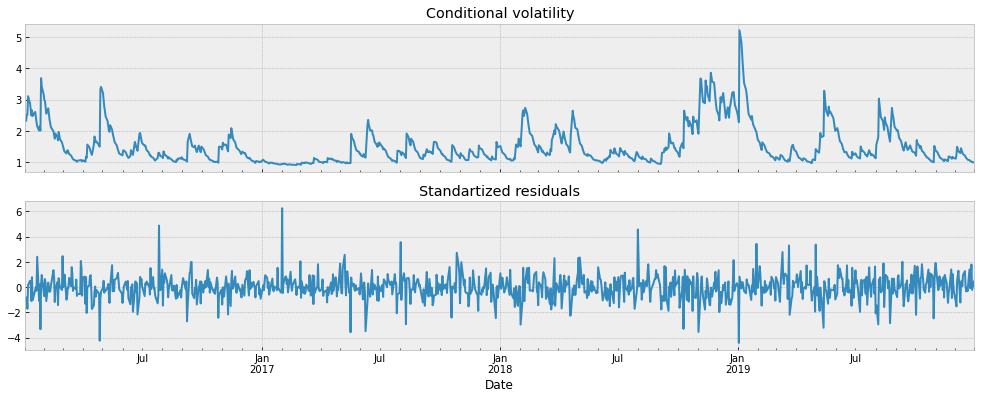

In [12]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

res.conditional_volatility.plot(ax=plt1.axes)
plt1.set_title('Conditional volatility')

(res.resid / res.conditional_volatility).plot(ax=plt2.axes)
plt2.set_title('Standartized residuals')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

And forecast conditional mean and variance

In [44]:
my_forecast = res.forecast(horizon=5)

print(my_forecast.mean.tail(4))
print(my_forecast.variance.tail(4))

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2019-12-24       NaN       NaN       NaN       NaN       NaN
2019-12-26       NaN       NaN       NaN       NaN       NaN
2019-12-27       NaN       NaN       NaN       NaN       NaN
2019-12-30  0.153347  0.144372  0.144191  0.144187  0.144187
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2019-12-24       NaN       NaN       NaN       NaN       NaN
2019-12-26       NaN       NaN       NaN       NaN       NaN
2019-12-27       NaN       NaN       NaN       NaN       NaN
2019-12-30  0.966853  1.049126  1.127721  1.203132  1.275489


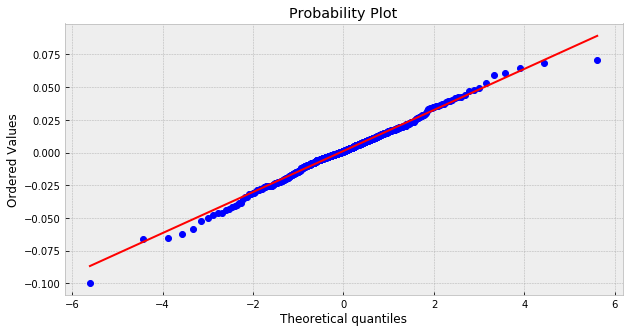

In [45]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=mdl.distribution, sparams=(res.params[-2:],), plot=plt)
plt.show()

#### Filtered Historical Simulation

In [54]:
# fit the model with normal ditribution
mdl = arch_model(100 * ret,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=2, o=2, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

res = mdl.fit(disp='off')

# get Standartized residuals
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()


# forecast mean and variance one step ahead
forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])


# conditional forecats return
conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
conditional_sr = conditional_sr / 100


# calculate VaR as quantile
VaR_FHS = conditional_sr.quantile(alpha)

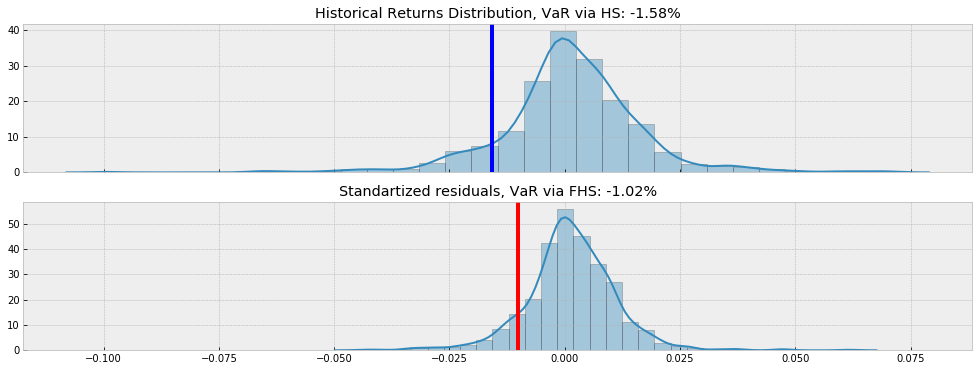

In [69]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(17, 6))

sns.distplot(ret, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Historical Returns Distribution, VaR via HS: {:.2f}%'.format(100*VaR_HS_10))
ax[0].axvline(x=VaR_HS_10, linewidth=4, color="b")

sns.distplot(conditional_sr, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Standartized residuals, VaR via FHS: {:.2f}%'.format(100*VaR_FHS))
ax[1].axvline(x=VaR_FHS, linewidth=4, color="r")

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

#### Wrapping into functions

In [46]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast


def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

    res = mdl.fit(disp='off')

   # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # calculate VaR as quantile
    VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_FHS

In [221]:
# VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=alpha)

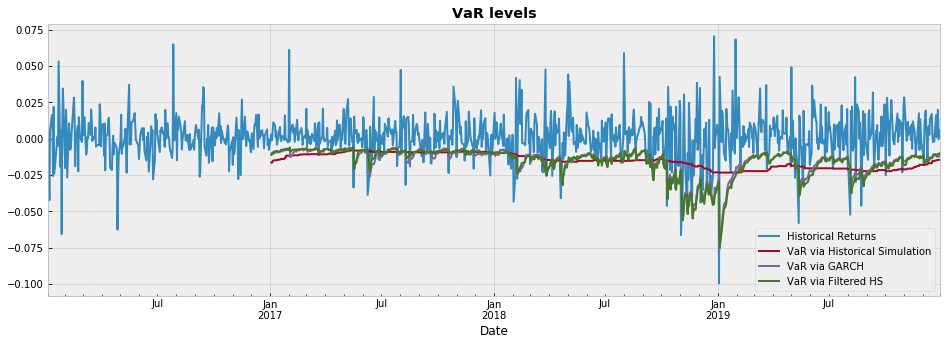

In [222]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot()
# VaR_t.plot()
VaR_garch.plot()
VaR_FHS.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via GARCH',
           'VaR via Filtered HS'])

plt.show()

## Backtesting VaR

In [47]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [48]:
hits = calc_hits(ret, VaR_t)
hits

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [49]:
hits.mean()

0.06640106241699867

In [50]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [51]:
def backtest_VaR(r, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [52]:
backtest_VaR(ret, VaR_HS, 1-alpha)
backtest_VaR(ret, VaR_t, 1-alpha)
# backtest_VaR(ret, VaR_garch, 1-alpha)
# backtest_VaR(ret, VaR_FHS, 1-alpha)

Backtesting calculate_VaR_HS:
The proportion of hits is 6.37% instead of expected 5.0%
Two-sided p-val 0.0936, one-sided: 0.0537
green zone

Backtesting calculate_VaR_t:
The proportion of hits is 6.64% instead of expected 5.0%
Two-sided p-val 0.0443, one-sided: 0.0276
yellow zone



## Homework

Download Microsoft stock price data for a period of '2017-07-01','2020-06-30' and calculate VaR curves using different approaches:

1. Use GARCH model with constant mean, EGARCH(2, 1, 2) and skewed t-student distribution of residuals
2. Use Generalized normal distribution (check this documenation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html)
3. Use a combination of GARCH and EVT: filter time series with GARCH and then model residuals with Excess Distribution Over a Threshold (hint: you need to take calculate_VaR_FHS() and "insert" a code from EVT section to the middle)


Then plot all VaR curves on one graph and conduct tests to select the most convenient approach. Finally, you should deliver:
1. One graph with daily historical returns and VaR curves
2. p-value for each model you use
3. Conclusion about what approach is the most suitable for this stock

In [3]:
r=[]
r.append(3)
r.append(4)

In [4]:
r

[3, 4]